In [1]:
import pandas as pd
import numpy as np

## IMPORTAMOS LAS BASES DE DATOS

In [2]:
df_nolabel = pd.read_csv('stock_tweets.csv')
df_label = pd.read_csv('tweets_labelled_09042020_16072020.csv', delimiter=';', quotechar='"', engine='python')

## LIMPIEZA

In [3]:
#CREAMOS FUNCIÓN DE LIMPIEZA
def limpieza(df, colum):
    L = df[[colum]].values.tolist()
    dc1 = []
    #Drop hyperlinks
    for i in range(len(L)):
        cad = L[i][0]
        cad = ' '.join([palabra.lower() for palabra in cad.split() if not palabra.startswith('https:')])
        dc1.append(cad)
    dc2 = []
    for i in dc1:
        if len([w for w in i if w.startswith('#')]) < 8:
            dc2.append(i)
        else:
            dc2.append("None")

    # Filter number of cashtags
    dc3 = []        
    for i in dc2:
        if len([w for w in i if w.startswith('$')]) < 5:
            dc3.append(i)
        else:
            dc3.append("None")

    # Filter ratios
    dc4 = []
    for i in dc3:
        if len([w for w in i if w.startswith('#')])/len(i.split()) <= 0.5 and len([w for w in i if w.startswith('$')])/len(i.split()) <= 0.5 and len([w for w in i if w.startswith('@')])/len(i.split()) <= 0.5:
            dc4.append(i)
        else: 
            dc4.append("None")
        

    # Filter cripto-tweets        
    crypto_keywords = ["bitcoin", "etherium", "btc", "eth", "nft", "token", "wallet", "web3", "airdrop", 
                   "wagmi", "solana", "opensea", "cryptopunks", "uniswap", "lunar", "hodl", "binance", 
                   "coinbase", "cryptocom", "doge"]

    dc5 = []
    for i in dc4:
        s = 0
        for j in i.split():
            if j in crypto_keywords:
                s += 1
        if s == 0:
            dc5.append(i)
        else:
            dc5.append("None")
    
    for j in range(len(dc5)):
        string = []
        for i in dc5[j]:
            if i.isdigit():
                i = '9'
            string.append(i)
        string = ''.join(string)
        dc5[j] = string
        
    dc6=[]   
    for j in dc5:
        string = []
        for i in j.split():
            if i.startswith('@'):
                i = '@user'
            string.append(i)
        string = ' '.join(string)
        dc6.append(string)

    return dc6


**LIMPIAMOS LA BASE DE DATOS SIN ETIQUETAS**

In [4]:
A=limpieza(df_nolabel, 'Tweet')
Tweets_limpios=pd.DataFrame(A)
df_nolabel["cleanTweet"] = Tweets_limpios

In [5]:
#dropeando columnas
df_nolabel = df_nolabel[df_nolabel['cleanTweet'] != 'None']
df_nolabel = df_nolabel.drop('Tweet', axis=1)

**LIMPIAMOS LA BASE DE DATOS CON ETIQUETAS**

In [6]:
B=limpieza(df_label, 'text')
Tweets_limpios1=pd.DataFrame(B)
df_label["Tweet"] = Tweets_limpios1
df_label
#dropeando columnas
df_label = df_label[df_label['Tweet'] != 'None']
df_label = df_label.drop('text', axis=1)

In [7]:
#Filtrando NaN
condicion = df_label['sentiment'].isin(['positive', 'negative', 'neutral'])
df_label_filtrado = df_label[condicion]
df_label_filtrado

,id,created_at,sentiment,Tweet
0,77522,2020-04-15 01:03:46+00:00,positive,"rt @user yo💥 enter to win 9,999 monarch tokens..."
1,661634,2020-06-25 06:20:06+00:00,negative,#srilanka surcharge on fuel removed! ⛽📉 the su...
2,413231,2020-06-04 15:41:45+00:00,positive,net issuance increases to fund fiscal programs...
3,760262,2020-07-03 19:39:35+00:00,positive,rt @user how much of amazon's traffic is serve...
4,830153,2020-07-09 14:39:14+00:00,positive,$amd ryzen 9999 desktop cpus looking ‘great’ a...
...,...,...,...,...
1294,917809,2020-07-15 11:47:27+00:00,neutral,"$unh - unitedhealth beats eps consensus, reite..."
1295,75519,2020-04-15 06:00:10+00:00,positive,#stocks back from the recovery room: fair valu...
1296,739234,2020-07-01 11:29:10+00:00,positive,rt @user breadth – expanding last week's discu...
1297,254379,2020-04-29 02:21:50+00:00,neutral,rt @user rompas-rajapalot: a big new camp. raj...


## ENTRENANDO EL MODELO

**SVM**

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score,precision_score


# Creamos un pipeline que combine el vectorizador TF-IDF con un clasificador SVM ( Support Vector Machine)
pipeline = Pipeline([ # Seguimiento de pasos

('tfidf', TfidfVectorizer(max_features=3000)), # convierte los tweets en una matriz de características TF-IDF.

('svm', SVC(C = 3 ,kernel='rbf',class_weight='balanced'))  # Usamos el clasificador SVC con un kernel lineal para encontrar un hiperplano optimo
])
# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(df_label_filtrado['Tweet'], df_label_filtrado['sentiment'], test_size=0.2, random_state=55)

# Entrenamos el modelo
pipeline.fit(X_train, y_train)

# Realizamos predicciones sobre el conjunto de prueba
y_pred = pipeline.predict(X_test)

# Evaluar el modelo
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

    negative       0.67      0.52      0.58        60
     neutral       0.69      0.60      0.64        57
    positive       0.59      0.75      0.66        81

    accuracy                           0.64       198
   macro avg       0.65      0.62      0.63       198
weighted avg       0.65      0.64      0.63       198



In [9]:
new_predictions = pipeline.predict(df_nolabel["cleanTweet"])
df_nolabel["sentiment-SVM"] = new_predictions
df_nolabel

,Date,Stock Name,Company Name,cleanTweet,sentiment-SVM
0,2022-09-29 23:41:16+00:00,TSLA,"Tesla, Inc.",mainstream media has done an amazing job at br...,positive
1,2022-09-29 23:24:43+00:00,TSLA,"Tesla, Inc.",tesla delivery estimates are at around 999k fr...,negative
3,2022-09-29 22:40:07+00:00,TSLA,"Tesla, Inc.",@user @user @user hahaha why are you still try...,positive
4,2022-09-29 22:27:05+00:00,TSLA,"Tesla, Inc.","@user @user stop trying to kill kids, you sad ...",negative
5,2022-09-29 22:25:53+00:00,TSLA,"Tesla, Inc.",@user @user this is you,positive
...,...,...,...,...,...
80784,2021-10-13 16:47:19+00:00,XPEV,XPeng Inc.,xpeng p9 tops sept sales among new ev makers i...,positive
80786,2021-10-11 03:51:36+00:00,XPEV,XPeng Inc.,"nio reached 999,999 vehicle rolled off the pro...",positive
80790,2021-10-01 04:43:41+00:00,XPEV,XPeng Inc.,our record delivery results are a testimony of...,positive
80791,2021-10-01 00:03:32+00:00,XPEV,XPeng Inc.,"we delivered 99,999 smart evs in sep 9999, rea...",positive


In [10]:
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable


## NUBE DE PALABRAS

In [11]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [12]:
valores = df_nolabel['Stock Name'].unique()
lista = valores.tolist()
valores_1 = df_nolabel['Company Name'].unique()
lista_1 = valores_1.tolist()
lista_1A = [name.split(',')[0].split()[0].lower() for name in lista_1]

In [13]:
import nltk
from nltk.corpus import stopwords

# Descargar la lista de stopwords si no está descargada
nltk.download('stopwords')

# Obtener la lista de stopwords en inglés
stopwords_english = list(set(stopwords.words('english')))

# Mostrar las primeras 10 stopwords en inglés
print(list(stopwords_english)[:10])


["you'd", "don't", 'wouldn', 'now', 'up', 'couldn', 'doesn', 'it', "needn't", 'then']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jd.mamanip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


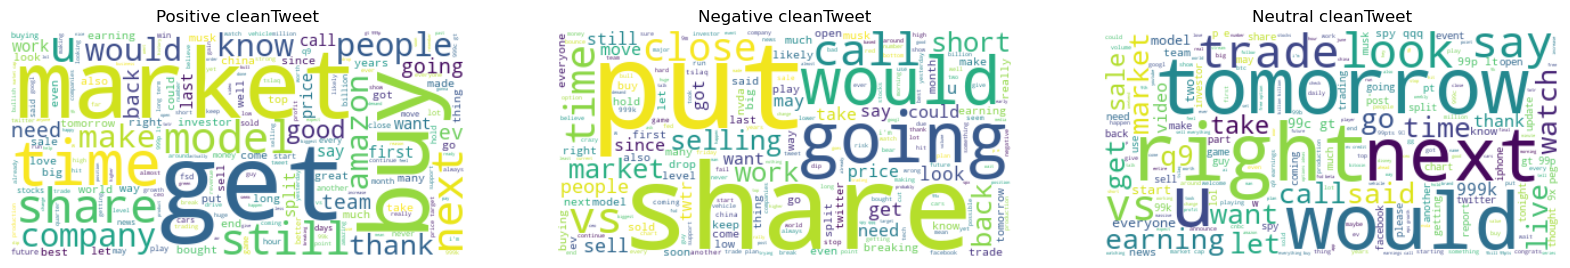

In [14]:
# Suponiendo que 'df' es tu DataFrame y ya está cargado con los datos correspondientes
# y la columna 'Sentiment' contiene las etiquetas de sentimiento y 'Tweet' los textos de los tweets.

# Lista de palabras para excluir de la nube de palabras
new = ["new","car","think","elon","week","one","day","year","today","amp","appl","amzn","fb","like","see","stock","my","so","was","V","are","is","user","and","but","if","of","to","on","for","s","as","wa","with","or","in","it","you","that","at","is","this","from","a","what","i"]
stopwords = lista + lista_1A + new + stopwords_english# Reemplaza con las palabras reales que deseas excluir

sentiments = ['positive', 'negative', 'neutral']
plt.figure(figsize=(20, 10))

# Crear una nube de palabras para cada sentimiento
for i, sentiment in enumerate(sentiments, 1):
    subset = df_nolabel[df_nolabel['sentiment-SVM'] == sentiment]
    text = " ".join(tweet for tweet in subset.cleanTweet)
    wordcloud = WordCloud(background_color='white', max_words=200, stopwords=stopwords)

    wordcloud.generate(text)
    plt.subplot(1, 3, i)
    plt.imshow(wordcloud, interpolation='bilinear')  # Agregado para mejorar la apariencia
    plt.title(sentiment.capitalize() + " cleanTweet")  # Agregado un espacio entre "cleanTweet" y la palabra "sentiment"
    plt.axis('off')
plt.savefig("Nube de palabras-SVM.jpg")
plt.show()


**Implementaciones de modelos opcionales**

**1. KNeighborsClassifier**

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

# Creamos un pipeline que combine el vectorizador TF-IDF con un clasificador k-NN
pipeline = Pipeline([ # Seguimiento de pasos
    ('tfidf', TfidfVectorizer(max_features=3000)), # convierte los textos en una matriz de características TF-IDF.
    ('knn', KNeighborsClassifier(n_neighbors=5)) # Usamos el clasificador k-NN. Puedes ajustar el número de vecinos.
])

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(df_label_filtrado["Tweet"], df_label_filtrado['sentiment'], test_size=0.2, random_state=42)

# Entrenamos el modelo
pipeline.fit(X_train, y_train)

# Realizamos predicciones sobre el conjunto de prueba
y_pred = pipeline.predict(X_test)

# Evaluar el modelo
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

    negative       0.54      0.48      0.51        58
     neutral       0.46      0.55      0.50        66
    positive       0.43      0.39      0.41        74

    accuracy                           0.47       198
   macro avg       0.48      0.47      0.47       198
weighted avg       0.47      0.47      0.47       198



In [16]:
print(accuracy)

0.4696969696969697


In [17]:
new_predictions = pipeline.predict(df_nolabel["cleanTweet"])
df_nolabel["sentiment KNC"] = new_predictions
df_nolabel

,Date,Stock Name,Company Name,cleanTweet,sentiment-SVM,sentiment KNC
0,2022-09-29 23:41:16+00:00,TSLA,"Tesla, Inc.",mainstream media has done an amazing job at br...,positive,negative
1,2022-09-29 23:24:43+00:00,TSLA,"Tesla, Inc.",tesla delivery estimates are at around 999k fr...,negative,positive
3,2022-09-29 22:40:07+00:00,TSLA,"Tesla, Inc.",@user @user @user hahaha why are you still try...,positive,negative
4,2022-09-29 22:27:05+00:00,TSLA,"Tesla, Inc.","@user @user stop trying to kill kids, you sad ...",negative,negative
5,2022-09-29 22:25:53+00:00,TSLA,"Tesla, Inc.",@user @user this is you,positive,neutral
...,...,...,...,...,...,...
80784,2021-10-13 16:47:19+00:00,XPEV,XPeng Inc.,xpeng p9 tops sept sales among new ev makers i...,positive,neutral
80786,2021-10-11 03:51:36+00:00,XPEV,XPeng Inc.,"nio reached 999,999 vehicle rolled off the pro...",positive,negative
80790,2021-10-01 04:43:41+00:00,XPEV,XPeng Inc.,our record delivery results are a testimony of...,positive,neutral
80791,2021-10-01 00:03:32+00:00,XPEV,XPeng Inc.,"we delivered 99,999 smart evs in sep 9999, rea...",positive,neutral


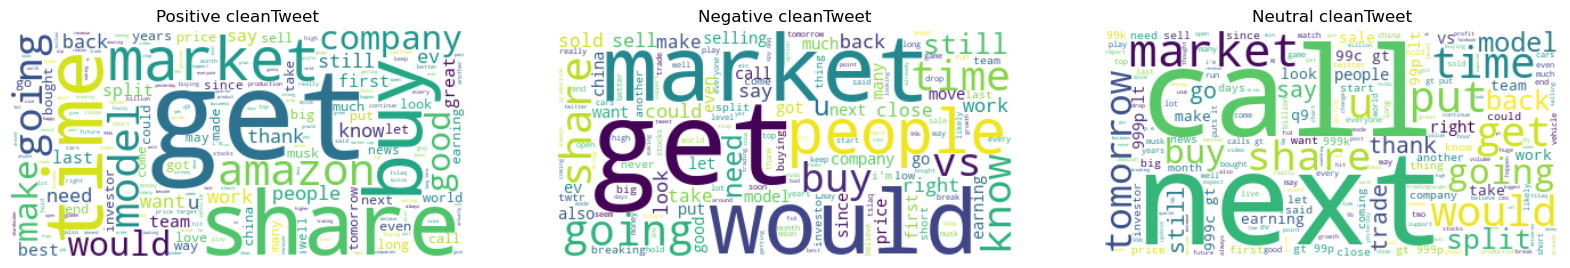

In [18]:
# Suponiendo que 'df' es tu DataFrame y ya está cargado con los datos correspondientes
# y la columna 'Sentiment' contiene las etiquetas de sentimiento y 'Tweet' los textos de los tweets.

# Lista de palabras para excluir de la nube de palabras
new = ["new","car","think","elon","week","one","day","year","today","amp","appl","amzn","fb","like","see","stock","my","so","was","V","are","is","user","and","but","if","of","to","on","for","s","as","wa","with","or","in","it","you","that","at","is","this","from","a","what","i"]
stopwords = lista + lista_1A + new + stopwords_english# Reemplaza con las palabras reales que deseas excluir

sentiments = ['positive', 'negative', 'neutral']
plt.figure(figsize=(20, 10))

# Crear una nube de palabras para cada sentimiento
for i, sentiment in enumerate(sentiments, 1):
    subset = df_nolabel[df_nolabel['sentiment KNC'] == sentiment]
    text = " ".join(tweet for tweet in subset.cleanTweet)
    wordcloud = WordCloud(background_color='white', max_words=200, stopwords=stopwords)

    wordcloud.generate(text)
    plt.subplot(1, 3, i)
    plt.imshow(wordcloud, interpolation='bilinear')  # Agregado para mejorar la apariencia
    plt.title(sentiment.capitalize() + " cleanTweet")  # Agregado un espacio entre "cleanTweet" y la palabra "sentiment"
    plt.axis('off')
plt.savefig("Nube de palabras-KNeighborsClassifier.jpg")
plt.show()

**2. LogisticRegression**

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

# Creamos un pipeline que combine el vectorizador TF-IDF con un clasificador de Regresión Logística
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000)),
    ('logistic', LogisticRegression(C=5.0, class_weight='balanced'))  # Usamos la regresión logística
])

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(df_label_filtrado["Tweet"],df_label_filtrado['sentiment'], test_size=0.2, random_state=42)

# Entrenamos el modelo
pipeline.fit(X_train, y_train)

# Realizamos predicciones sobre el conjunto de prueba
y_pred = pipeline.predict(X_test)

# Evaluar el modelo
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(report)


              precision    recall  f1-score   support

    negative       0.55      0.57      0.56        58
     neutral       0.56      0.48      0.52        66
    positive       0.59      0.65      0.62        74

    accuracy                           0.57       198
   macro avg       0.57      0.57      0.57       198
weighted avg       0.57      0.57      0.57       198



In [20]:
print(accuracy)

0.5707070707070707


In [21]:
new_predictions = pipeline.predict(df_nolabel["cleanTweet"])
df_nolabel["sentiment-LR"] = new_predictions
df_nolabel

,Date,Stock Name,Company Name,cleanTweet,sentiment-SVM,sentiment KNC,sentiment-LR
0,2022-09-29 23:41:16+00:00,TSLA,"Tesla, Inc.",mainstream media has done an amazing job at br...,positive,negative,negative
1,2022-09-29 23:24:43+00:00,TSLA,"Tesla, Inc.",tesla delivery estimates are at around 999k fr...,negative,positive,negative
3,2022-09-29 22:40:07+00:00,TSLA,"Tesla, Inc.",@user @user @user hahaha why are you still try...,positive,negative,positive
4,2022-09-29 22:27:05+00:00,TSLA,"Tesla, Inc.","@user @user stop trying to kill kids, you sad ...",negative,negative,negative
5,2022-09-29 22:25:53+00:00,TSLA,"Tesla, Inc.",@user @user this is you,positive,neutral,positive
...,...,...,...,...,...,...,...
80784,2021-10-13 16:47:19+00:00,XPEV,XPeng Inc.,xpeng p9 tops sept sales among new ev makers i...,positive,neutral,neutral
80786,2021-10-11 03:51:36+00:00,XPEV,XPeng Inc.,"nio reached 999,999 vehicle rolled off the pro...",positive,negative,negative
80790,2021-10-01 04:43:41+00:00,XPEV,XPeng Inc.,our record delivery results are a testimony of...,positive,neutral,positive
80791,2021-10-01 00:03:32+00:00,XPEV,XPeng Inc.,"we delivered 99,999 smart evs in sep 9999, rea...",positive,neutral,positive


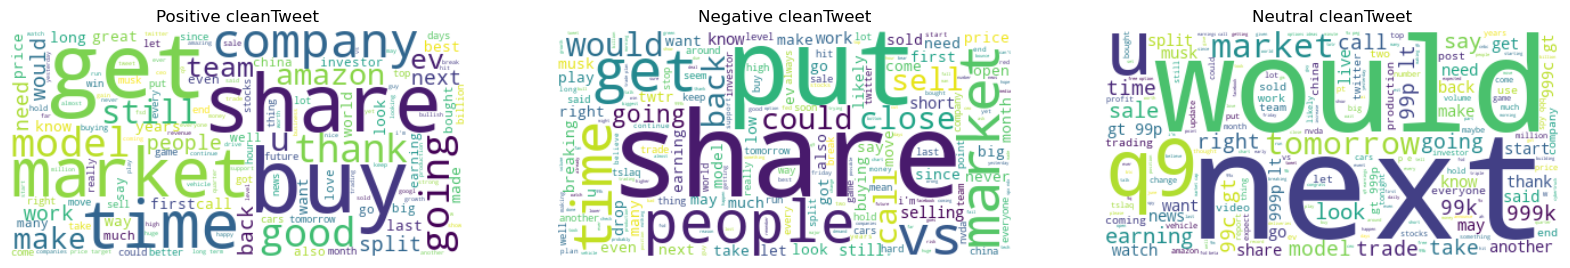

In [22]:
#creamos nuestra propia list de stopwords en la lista New
new = ["new","car","think","elon","week","one","day","year","today","amp","appl","amzn","fb","like","see","stock","my","so","was","V","are","is","user","and","but","if","of","to","on","for","s","as","wa","with","or","in","it","you","that","at","is","this","from","a","what","i"]
stopwords = lista + lista_1A + new + stopwords_english# Reemplaza con las palabras reales que deseas excluir

sentiments = ['positive', 'negative', 'neutral']
plt.figure(figsize=(20, 10))

# Crear una nube de palabras para cada sentimiento
for i, sentiment in enumerate(sentiments, 1):
    subset = df_nolabel[df_nolabel['sentiment-LR'] == sentiment]
    text = " ".join(tweet for tweet in subset.cleanTweet)
    wordcloud = WordCloud(background_color='white', max_words=200, stopwords=stopwords)

    wordcloud.generate(text)
    plt.subplot(1, 3, i)
    plt.imshow(wordcloud, interpolation='bilinear')  # Agregado para mejorar la apariencia
    plt.title(sentiment.capitalize() + " cleanTweet")  # Agregado un espacio entre "cleanTweet" y la palabra "sentiment"
    plt.axis('off')
plt.savefig("Nube de palabras-LogisticRegression.jpg")
plt.show()

**3. Naive_Bayes**

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

# Creamos un pipeline que combine el vectorizador TF-IDF con un clasificador Naive Bayes
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.9, min_df=3)),
    ('naive_bayes', MultinomialNB())  # Usamos el clasificador Naive Bayes
])

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(df_label_filtrado["Tweet"],df_label_filtrado['sentiment'], test_size=0.2, random_state=42)


# Entrenamos el modelo
pipeline.fit(X_train, y_train)

# Realizamos predicciones sobre el conjunto de prueba
y_pred = pipeline.predict(X_test)

# Evaluar el modelo
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(report)


              precision    recall  f1-score   support

    negative       0.59      0.17      0.27        58
     neutral       0.69      0.30      0.42        66
    positive       0.41      0.85      0.56        74

    accuracy                           0.47       198
   macro avg       0.56      0.44      0.42       198
weighted avg       0.56      0.47      0.43       198



In [24]:
print(accuracy)

0.4696969696969697


In [25]:
new_predictions = pipeline.predict(df_nolabel["cleanTweet"])
df_nolabel["sentiment-NB"] = new_predictions
df_nolabel

,Date,Stock Name,Company Name,cleanTweet,sentiment-SVM,sentiment KNC,sentiment-LR,sentiment-NB
0,2022-09-29 23:41:16+00:00,TSLA,"Tesla, Inc.",mainstream media has done an amazing job at br...,positive,negative,negative,negative
1,2022-09-29 23:24:43+00:00,TSLA,"Tesla, Inc.",tesla delivery estimates are at around 999k fr...,negative,positive,negative,negative
3,2022-09-29 22:40:07+00:00,TSLA,"Tesla, Inc.",@user @user @user hahaha why are you still try...,positive,negative,positive,positive
4,2022-09-29 22:27:05+00:00,TSLA,"Tesla, Inc.","@user @user stop trying to kill kids, you sad ...",negative,negative,negative,negative
5,2022-09-29 22:25:53+00:00,TSLA,"Tesla, Inc.",@user @user this is you,positive,neutral,positive,positive
...,...,...,...,...,...,...,...,...
80784,2021-10-13 16:47:19+00:00,XPEV,XPeng Inc.,xpeng p9 tops sept sales among new ev makers i...,positive,neutral,neutral,neutral
80786,2021-10-11 03:51:36+00:00,XPEV,XPeng Inc.,"nio reached 999,999 vehicle rolled off the pro...",positive,negative,negative,positive
80790,2021-10-01 04:43:41+00:00,XPEV,XPeng Inc.,our record delivery results are a testimony of...,positive,neutral,positive,positive
80791,2021-10-01 00:03:32+00:00,XPEV,XPeng Inc.,"we delivered 99,999 smart evs in sep 9999, rea...",positive,neutral,positive,positive


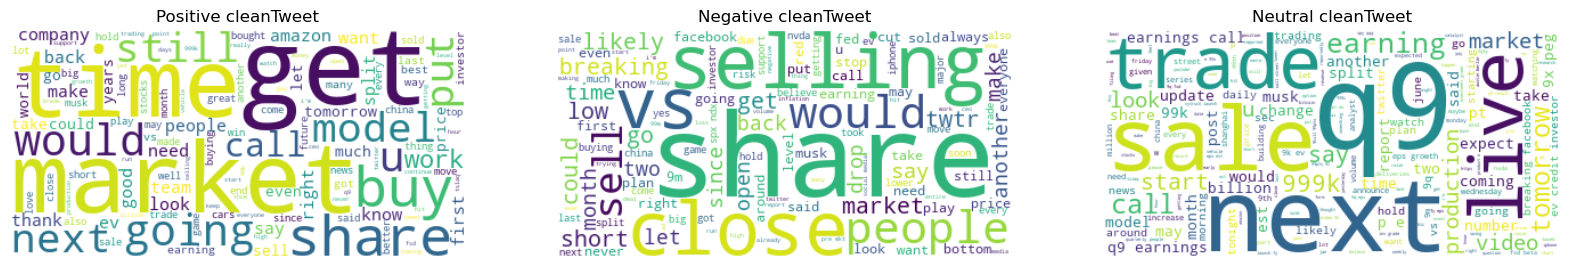

In [26]:
new = ["new","car","think","elon","week","one","day","year","today","amp","appl","amzn","fb","like","see","stock","my","so","was","V","are","is","user","and","but","if","of","to","on","for","s","as","wa","with","or","in","it","you","that","at","is","this","from","a","what","i"]
stopwords = lista + lista_1A + new + stopwords_english# Reemplaza con las palabras reales que deseas excluir

sentiments = ['positive', 'negative', 'neutral']
plt.figure(figsize=(20, 10))

# Crear una nube de palabras para cada sentimiento
for i, sentiment in enumerate(sentiments, 1):
    subset = df_nolabel[df_nolabel['sentiment-NB'] == sentiment]
    text = " ".join(tweet for tweet in subset.cleanTweet)
    wordcloud = WordCloud(background_color='white', max_words=200, stopwords=stopwords)

    wordcloud.generate(text)
    plt.subplot(1, 3, i)
    plt.imshow(wordcloud, interpolation='bilinear')  # Agregado para mejorar la apariencia
    plt.title(sentiment.capitalize() + " cleanTweet")  # Agregado un espacio entre "cleanTweet" y la palabra "sentiment"
    plt.axis('off')
plt.savefig("Nube de palabras-Naive_Bayes.jpg")
plt.show()

**Importando la base de datos que contiene la evolución de los precios de las acciones**


In [27]:
df_prices = pd.read_csv('stock_yfinance_data.csv')
df_prices[:10]

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA
5,2021-10-07,261.820007,268.333344,261.126678,264.536682,264.536682,57587400,TSLA
6,2021-10-08,265.403320,265.459991,260.303345,261.829987,261.829987,50215800,TSLA
7,2021-10-11,262.549988,267.079987,261.833344,263.980011,263.980011,42600900,TSLA
8,2021-10-12,266.976654,270.773346,265.523346,268.573334,268.573334,66060000,TSLA
9,2021-10-13,270.156677,271.803345,268.593323,270.359985,270.359985,42360300,TSLA


In [28]:
##función que devuelve información del precio y los tweets sobre "company" en la fecha "Date"
def tweet_pricevolution(company,Date,rango):
    condicion1 = df_prices['Stock Name'].str.startswith(company) & df_prices['Date'].str.startswith(Date)
    condicion2 = df_nolabel['Stock Name'].str.startswith(company) & df_nolabel['Date'].str.startswith(Date)
    #condición aplicada al dataset de precios
    df_prices_filt1 = df_prices[condicion1]
    #condición aplicada al dataset de de tweets

    df_filtrado = df_nolabel[condicion2]

    #conteo para evaluar el sentimente del mercado
    conteo_positive = (df_filtrado['sentiment-SVM'].str.contains('positive')).sum()
    conteo_negative = (df_filtrado['sentiment-SVM'].str.contains('negative')).sum()
    conteo_neutral = (df_filtrado['sentiment-SVM'].str.contains('neutral')).sum()
    
    return df_prices_filt1,df_filtrado, conteo_positive , conteo_negative , conteo_neutral

In [29]:
precios, tweets,_,_,_ = tweet_pricevolution("TSLA","2",0)

In [30]:
precios

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA
...,...,...,...,...,...,...,...,...
247,2022-09-23,283.089996,284.500000,272.820007,275.329987,275.329987,63748400,TSLA
248,2022-09-26,271.829987,284.089996,270.309998,276.010010,276.010010,58076900,TSLA
249,2022-09-27,283.839996,288.670013,277.510010,282.940002,282.940002,61925200,TSLA
250,2022-09-28,283.079987,289.000000,277.570007,287.809998,287.809998,54664800,TSLA


In [31]:
#exportando la base de datos a excel
nombre_archivo_excel = 'proyecto1.xlsx'
nombre_hoja_excel = 'hoja_datos'
precios.to_excel(nombre_archivo_excel, index=False)

In [32]:
tweets

,Date,Stock Name,Company Name,cleanTweet,sentiment-SVM,sentiment KNC,sentiment-LR,sentiment-NB
0,2022-09-29 23:41:16+00:00,TSLA,"Tesla, Inc.",mainstream media has done an amazing job at br...,positive,negative,negative,negative
1,2022-09-29 23:24:43+00:00,TSLA,"Tesla, Inc.",tesla delivery estimates are at around 999k fr...,negative,positive,negative,negative
3,2022-09-29 22:40:07+00:00,TSLA,"Tesla, Inc.",@user @user @user hahaha why are you still try...,positive,negative,positive,positive
4,2022-09-29 22:27:05+00:00,TSLA,"Tesla, Inc.","@user @user stop trying to kill kids, you sad ...",negative,negative,negative,negative
5,2022-09-29 22:25:53+00:00,TSLA,"Tesla, Inc.",@user @user this is you,positive,neutral,positive,positive
...,...,...,...,...,...,...,...,...
37417,2021-09-30 02:52:38+00:00,TSLA,"Tesla, Inc.",playing in the dirt and #chasingsunsets @user ...,neutral,neutral,positive,positive
37418,2021-09-30 02:40:26+00:00,TSLA,"Tesla, Inc.",i agree with @user that $tsla ‘s ev business a...,positive,positive,positive,positive
37419,2021-09-30 01:59:02+00:00,TSLA,"Tesla, Inc.",hold. on. tight. $tsla,negative,neutral,neutral,neutral
37420,2021-09-30 01:38:26+00:00,TSLA,"Tesla, Inc.",get ready for a $tsla _ _ _ _ _ _ q9 delivery ...,positive,positive,neutral,positive
